# Curating taxonomy using tax2tree

[**tax2tree**](https://github.com/wasade/tax2tree) ([McDonald et al., 2012](https://www.nature.com/articles/ismej2011139)) automatically curates taxonomic annotations of tree tips and internal nodes based on tree topology. This notebook explains how tax2tree is executed and parses its output files to generate more information.

## Usage of tax2tree

### Installation

In [1]:
%%script false
!conda create -n tax2tree numpy Click future==0.13.1 scikit-bio==0.2.3 python=2
!source activate tax2tree
!pip install git+https://github.com/wasade/tax2tree.git
!source activate tax2tree

### Input files

A tree in Newick format:

In [49]:
!cat tree.nwk | cut -c1-500

((((G001871475:0.6649017437,G001871535:0.7495271859)N8:0.3585565618,((G000830275:0.4402637632,G000402355:0.5620921743)N15:0.4016110066,(G000830295:0.6765514677,G001871415:0.8393580422)N16:0.1723565823)N9:0.1265650303)N4:0.1030291448,((((G001940755:0.8101170743,(G001940725:0.7173617886,G001940645:0.7113680113)N45:0.2167779333)N27:0.1310809933,(G001940655:0.9292717238,(G001563325:0.3213034238,(G001940705:0.1529373108,G001563335:0.1813806477)N70:0.1429604754)N46:0.4839664797)N28:0.1054502537)N17:0.


A genome ID to lineage str (taxa at the seven ranks) map:

In [50]:
!head -n5 lineages.txt

G000005825	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus pseudofirmus
G000006175	k__Archaea; p__Euryarchaeota; c__Methanococci; o__Methanococcales; f__Methanococcaceae; g__Methanococcus; s__Methanococcus voltae
G000006605	k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Corynebacteriaceae; g__Corynebacterium; s__Corynebacterium jeikeium
G000006725	k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Xylella; s__Xylella fastidiosa
G000006745	k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Vibrionaceae; g__Vibrio; s__Vibrio cholerae


### Run tax2tree

Decorate the tree with taxonomy.

In [4]:
%%script false
!t2t decorate -t tree.nwk -m lineages.txt -o decorated.nwk > tax2tree.stdout
!mv decorated.nwk-consensus-strings consensus_strings.txt

Assess the consistency between taxdump and topology.

In [5]:
%%script false
!t2t consistency -t tree.nwk -m lineages.txt -o consistency.tsv >> tax2tree.stdout

### Output files

Tree with selected nodes decorated with lineage strings:

In [51]:
!cat decorated.nwk | cut -c1-500

((((G001871475:0.6649017437,G001871535:0.7495271859)'p__Candidatus Micrarchaeota':0.3585565618,((G000830275:0.4402637632,G000402355:0.5620921743):0.4016110066,(G000830295:0.6765514677,G001871415:0.8393580422):0.1723565823):0.1265650303):0.1030291448,((((G001940755:0.8101170743,(G001940725:0.7173617886,G001940645:0.7113680113):0.2167779333):0.1310809933,(G001940655:0.9292717238,(G001563325:0.3213034238,(G001940705:0.1529373108,G001563335:0.1813806477):0.1429604754)'p__Candidatus Thorarchaeota':0.


Consensus strings (taxon to lineage map):

In [52]:
!head -n5 consensus_strings.txt

G001871475	k__Archaea; p__Candidatus Micrarchaeota; c__; o__; f__; g__; s__
G001871535	k__Archaea; p__Candidatus Micrarchaeota; c__; o__; f__; g__; s__
G000830275	k__Archaea; p__; c__; o__; f__; g__; s__
G000402355	k__Archaea; p__; c__; o__; f__; g__; s__
G000830295	k__Archaea; p__; c__; o__; f__; g__; s__


Consistency analysis result:

In [53]:
!head -n5 consistency.tsv

Taxon	Count	Consistency
k__Archaea	652	1.000
k__Bacteria	9574	1.000
p__Candidatus Adlerbacteria	5	1.000
p__Thermotogae	35	1.000


## Preparation

### Dependencies

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skbio import TreeNode

In [10]:
%matplotlib inline

### Input files

Original tree (with unique internal node IDs).

In [11]:
tree_ori_fp = 'tree.nwk'

Decorated tree (internal node IDs removed and some nodes appended lineage strings).

In [12]:
tree_dec_fp = 'decorated.nwk'

Original genome to lineage map.

In [13]:
lineage_ori_fp = 'lineages.txt'

Consensus strings (genom to lineage string map).

In [14]:
cons_str_fp = 'consensus_strings.txt'

Consistency analysis result.

In [15]:
consist_fp = 'consistency.tsv'

### Parameters

Ranks and codes.

In [16]:
ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
code2rank = {x[0]: x for x in ranks}

### Utilities

In [17]:
def save_sns(ax, fp):
    plt = ax.get_figure()
    plt.tight_layout()
    plt.savefig(fp, bbox_to_inches='tight')

Read genome to lineage map into dataframe.

In [18]:
def lineages_to_df(lineage_fp):
    g2lin = {}
    with open(lineage_fp, 'r') as f:
        for line in f:
            g, lineage = line.rstrip('\r\n').split('\t')
            g2lin[g] = dict(zip(ranks, [x.split('__')[1] for x in lineage.split('; ')]))
    df = pd.DataFrame.from_dict(g2lin, orient='index')
    return df.loc[sorted(g2lin, key=lambda x: int(x[1:]))]

Export by-rank dataframe as lineage strings.

In [19]:
def df_to_lineages(df, f):
    for row in df.itertuples():
        lin = []
        for i, rank in enumerate(ranks):
            lin.append('%s__%s' % (rank[0], row[i + 1]))
        f.write('%s\t%s\n' % (row.Index, '; '.join(lin)))

## Analysis

### Curated taxonomy

Read consensus strings.

In [20]:
dfc = lineages_to_df(cons_str_fp)
dfc.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes_1,Bacilli,Bacillales_2,Bacillaceae_1,Bacillus_2,
G000006175,Archaea,Euryarchaeota_1,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,
G000006605,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium falsenii
G000006725,Bacteria,Proteobacteria_1,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,
G000006745,Bacteria,Proteobacteria_1,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,


Note: In tax2tree's assumption, all lineages should be continuous (i.e., a continuous series of ranks should all contain taxa). However in reality some lineages contain caps. For example:

`G001458535 k__Bacteria; p__Candidatus Kryptonia; c__; o__; f__; g__Candidatus Kryptonium; s__Candidatus Kryptonium thompsoni`

In those cases tax2tree may produced gapped consensus strings.

Convert to table.

In [21]:
dfc.to_csv('consensus_ranks.tsv', sep='\t')

### Analyze polytomies

Taxon names ending with `__#` are the ones identified as polytomies and split into multiple taxa by tax2tree.

In [22]:
splits = {}
for rank in ranks:
    split_names = {}
    for name in set(x for x in dfc[rank] if x):
        x = name.split('_')
        # convert "taxonA_1" into "taxonA"
        if len(x) > 1 and x[-1].isdigit():
            ori_name = '_'.join(x[:-1])
            # get all appended indices for each taxon
            if ori_name in split_names:
                split_names[ori_name].append(int(x[-1]))
            else:
                split_names[ori_name] = [int(x[-1])]

    splits[rank] = {}
    for name in sorted(split_names):
        indices = split_names[name]
        # check if the indices are incremental integers
        if sorted(indices) != list(range(1, max(indices) + 1)):
            print('%s: %s is not a split.' % (rank, name))
            continue
        splits[rank][name] = len(indices)

species: Peptococcaceae bacterium SCADC1_2 is not a split.


Get original names that appear in the curated table.

In [23]:
ori_names = {}
for rank in ranks:
    ori_names[rank] = set()
    for name in set(x for x in dfc[rank] if x):
        x = name.split('_')
        if len(x) > 1 and x[-1].isdigit():
            name_ = '_'.join(x[:-1])
            if name_ in splits[rank]:
                ori_names[rank].add(name_)
            else:
                ori_names[rank].add(name)
        else:
            ori_names[rank].add(name)
print(', '.join('%s: %d' % (x, len(ori_names[x])) for x in ranks))

kingdom: 2, phylum: 115, class: 73, order: 160, family: 321, genus: 785, species: 419


Export results.

In [24]:
with open('split_taxa.tsv', 'w') as f:
    f.write('rank\ttaxon\tsplits\n')
    for rank in ranks:
        d = splits[rank]
        if len(d) > 0:
            max_name = max(d.keys(), key=(lambda k: d[k]))
            print('%s: %d taxa split, max = %s (%s)'
                  % (rank, len(d), d[max_name], max_name))
            for name in sorted(d):
                f.write('%s\t%s\t%d\n' % (rank, name, d[name]))

phylum: 5 taxa split, max = 13 (Firmicutes)
class: 7 taxa split, max = 9 (Clostridia)
order: 26 taxa split, max = 14 (Bacillales)
family: 47 taxa split, max = 6 (Bacillaceae)
genus: 17 taxa split, max = 6 (Bacillus)


### Analyze consistency

In [25]:
dfp = pd.read_table(consist_fp)
dfp.head()

,Taxon,Count,Consistency
0,k__Archaea,652,1.0
1,k__Bacteria,9574,1.0
2,p__Candidatus Adlerbacteria,5,1.0
3,p__Thermotogae,35,1.0
4,p__Candidatus Doudnabacteria,19,1.0


In [26]:
dfp['Name'] = dfp['Taxon'].str.split('__').str.get(1)
dfp['Rank'] = dfp['Taxon'].str.split('__').str.get(0).map(code2rank)
dfp.set_index('Taxon', inplace=True)
dfp.head()

,Count,Consistency,Name,Rank
Taxon,,,,
k__Archaea,652,1.0,Archaea,kingdom
k__Bacteria,9574,1.0,Bacteria,kingdom
p__Candidatus Adlerbacteria,5,1.0,Candidatus Adlerbacteria,phylum
p__Thermotogae,35,1.0,Thermotogae,phylum
p__Candidatus Doudnabacteria,19,1.0,Candidatus Doudnabacteria,phylum


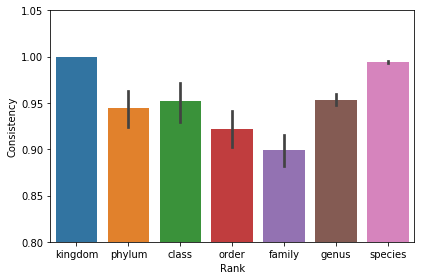

In [27]:
ax = sns.barplot(x='Rank', y='Consistency', data=dfp)
ax.set_ylim(0.8,)
save_sns(ax, 'consistency.pdf')

### Fill spaces with unique taxa

tax2tree-curated taxa are the ones that occur more than once in the table. However many genomes are the only representatives of some taxa, especially the species level. Therefore, the empty cells will be filled with unique taxa when applicable.

Note the those added taxa are NOT tax2tree-curated taxa. They are but unique identifiers of certain genomes.

Read original lineages.

In [28]:
dfo = lineages_to_df(lineage_ori_fp)
dfo.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus pseudofirmus
G000006175,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,Methanococcus voltae
G000006605,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium jeikeium
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,Xylella fastidiosa
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio cholerae


Identify taxa from the original lineages that can be filled to trailing spaces following consensus strings.

In [29]:
taxa_to_add = {x: {} for x in ranks}
for g in dfc.index:
    for rank in ranks:
        if dfc[rank][g] == '':
            taxon = dfo[rank][g]
            if taxon != '' and not taxon in ori_names[rank]:
                taxa_to_add[rank][g] = taxon
print(', '.join('%s: %d' % (x, len(taxa_to_add[x])) for x in ranks))

kingdom: 0, phylum: 40, class: 8, order: 23, family: 79, genus: 1200, species: 8474


Exclude taxa that occur multiple times at each rank.

In [30]:
for rank in ranks:
    used, dups = set(), set()
    for g, taxon in taxa_to_add[rank].items():
        if taxon in used:
            dups.add(taxon)
        used.add(taxon)
    new_dict = {}
    for g, taxon in taxa_to_add[rank].items():
        if taxon not in dups:
            new_dict[g] = taxon
    taxa_to_add[rank] = new_dict
print(', '.join('%s: %d' % (x, len(taxa_to_add[x])) for x in ranks))

kingdom: 0, phylum: 20, class: 8, order: 23, family: 66, genus: 1062, species: 8426


Add those taxa to the lineage table.

In [31]:
dfl = dfc.copy(deep=True)
for i, rank in enumerate(ranks):
    for g, taxon in taxa_to_add[rank].items():
        dfl[rank][g] = taxon
dfl.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes_1,Bacilli,Bacillales_2,Bacillaceae_1,Bacillus_2,Bacillus pseudofirmus
G000006175,Archaea,Euryarchaeota_1,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,Methanococcus voltae
G000006605,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium falsenii
G000006725,Bacteria,Proteobacteria_1,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,Xylella fastidiosa
G000006745,Bacteria,Proteobacteria_1,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio cholerae


In [32]:
dfl.to_csv('filled_ranks.tsv', sep='\t')

In [33]:
with open('filled_lineages.txt', 'w') as f:
    df_to_lineages(dfl, f)

### Analyze node decoration

Match decorations and node IDs.

In [34]:
tree_ori = TreeNode.read(tree_ori_fp)
tree_ori.count(tips=True)

10575

In [35]:
tree_dec = TreeNode.read(tree_dec_fp)
tree_dec.count(tips=True)

10575

Confirm that the decorated tree has the same topology and order of taxa as the original tree.

In [36]:
tree_ori.compare_rfd(tree_dec)

0.0

Read internal node IDs from the original tree.

In [37]:
nids = []
for node in tree_ori.levelorder():
    if not node.is_tip():
        nids.append(node.name)

Read node decorations.

In [38]:
decos = []
for node in tree_dec.levelorder():
    if not node.is_tip():
        decos.append(node.name)
decos[:5]

[None, 'k__Archaea', 'k__Bacteria', None, None]

Generate a rank name table.

In [39]:
nid2label = {}
nid2ranks = {}
for i in range(len(nids)):
    nid = nids[i]
    deco = decos[i]
    nid2ranks[nid] = {x: '' for x in ranks}
    if deco is not None and '__' in deco:
        deco = deco.split(':')[-1]  # remove node support in case there is one
        nid2label[nid] = deco
        for taxon in deco.split('; '):
            code, name = taxon.split('__')
            nid2ranks[nid][code2rank[code]] = name

In [40]:
with open('decorations.txt', 'w') as f:
    for nid in sorted(nid2label, key=lambda x: int(x.lstrip('N'))):
        f.write('%s\t%s\n' % (nid, nid2label[nid]))

In [41]:
dfd = pd.DataFrame.from_dict(nid2ranks, orient='index')
dfd = dfd.loc[sorted(nid2ranks, key=lambda x: int(x[1:]))]
dfd.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,,,,,,,
N5,,,,,,,


In [42]:
dfd.to_csv('decorations_by_rank.tsv', sep='\t')

### Generate lineage for every node

At a given node, at each rank, check if one taxon can describe all descendants.

In [43]:
g2ranks = dfl.to_dict('index')

In [44]:
nid2ranks, nid2lineage = {}, {}
for nid in nids:
    nid2ranks[nid] = {x: '' for x in ranks}
    nid2lineage[nid] = []
    gs = tree_ori.find(nid).subset()
    for rank in ranks:
        nid2lineage[nid].append('%s__' % rank[0])
        names = set(g2ranks[x][rank] for x in gs)
        if len(names) == 1:
            name = max(names)
            nid2ranks[nid][rank] = name
            nid2lineage[nid][-1] += name

In [45]:
with open('node_lineages.txt', 'w') as f:
    for nid in sorted(nid2lineage, key=lambda x: int(x[1:])):
        f.write('%s\t%s\n' % (nid, '; '.join(nid2lineage[nid])))

In [46]:
dfn = pd.DataFrame.from_dict(nid2ranks, orient='index')
dfn = dfn.loc[sorted(nid2ranks, key=lambda x: int(x[1:]))]
dfn.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,Archaea,,,,,,
N5,Archaea,,,,,,


In [47]:
dfn.to_csv('node_ranks.tsv', sep='\t')